In [1]:
import math
import torch
from torch import nn
from d2l import torch as d2l

In [18]:
#@save
def masked_softmax(X, valid_lens):
    """Perform softmax operation by masking elements on the last axis."""
    if valid_lens is None:
        return nn.functional.softmax(X, dim=-1)
    else:
        shape = X.shape
        if valid_lens.dim() == 1:
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])
        else:
            valid_lens = valid_lens.reshape(-1)
        # Fill masked elements with a large negative, whose exp is 0
        X = d2l.sequence_mask(X.reshape(-1, shape[-1]), valid_lens, value=-1e6)
        return nn.functional.softmax(X.reshape(shape), dim=-1)

In [19]:
masked_softmax(torch.rand(2, 2, 4), torch.tensor([2, 3]))
# valid_lens will be changed to [2, 2, 2, 3] by repeat_interleave
# X will be changed to shape (2*2, 4) = (4, 4) by reshape

tensor([[[0.5551, 0.4449, 0.0000, 0.0000],
         [0.4296, 0.5704, 0.0000, 0.0000]],

        [[0.2461, 0.3653, 0.3886, 0.0000],
         [0.2392, 0.5323, 0.2286, 0.0000]]])

In [20]:
masked_softmax(torch.rand(2, 2, 4), torch.tensor([[1, 3], [2, 4]]))
# valid_lens will be changed to [1, 3, 2, 4] by reshape
# X will be changed to [4, 4] by sequence_mask

tensor([[[1.0000, 0.0000, 0.0000, 0.0000],
         [0.2915, 0.3817, 0.3268, 0.0000]],

        [[0.4672, 0.5328, 0.0000, 0.0000],
         [0.3049, 0.2969, 0.1730, 0.2253]]])

### Additive attention

In [21]:
#@save
class AdditivaAttention(nn.Module):
    def __init__(self, key_size, query_size, value_size, num_hiddens, dropout, **kwargs):
        super(AdditivaAttention, self).__init__(**kwargs)
        self.W_k = nn.Linear(key_size, num_hiddens, bias=False)
        self.W_q = nn.Linear(query_size, num_hiddens, bias=False)
        self.W_v = nn.Linear(value_size, num_hiddens, bias=False)
        self.W_o = nn.Linear(num_hiddens, 1, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, queries, keys, values, valid_lens):
        # shape of queries, keys, values: (batch_size, no. of queries/keys/keys, key_size/query_size/value_size)
        queries, keys = self.W_q(queries), self.W_k(keys)
        
        # After dimension expansion, shape of `queries`: (`batch_size`, no. of queries, 1, `num_hiddens`)
        # After dimension expansion, shape of `keys`: (`batch_size`, 1, no. of key-value pairs, `num_hiddens`)
        # Sum them up with broacasting, shape of `features`: (`batch_size`, no. of queries, no. of key-value pairs, `num_hiddens`)
        features = queries.unsqueeze(2) + keys.unsqueeze(1)
        
        # Shape of `scores`: (`batch_size`, no. of queries, no. of key-value pairs)
        scores = self.W_o(torch.tanh(features)).squeeze(-1)
        self.attention_weights = masked_softmax(scores, valid_lens)
        
        # shape of result: (batch_size, no. of queries, value_size)
        return torch.bmm(self.dropout(self.attention_weights), values)

In [22]:
queries, keys = torch.normal(0, 1, (2, 1, 20)), torch.ones((2, 10, 2))
# The two value matrices in the `values` minibatch are identical
# shape of values: (2, 10, 4)
values = torch.arange(40, dtype=torch.float32).reshape(1, 10, 4).repeat(2, 1, 1)
valid_lens = torch.tensor([2, 6])
attention = AdditivaAttention(key_size=2, query_size=20, value_size=4, num_hiddens=8, dropout=0.1)
attention.eval()
# shape of attention(queries, keys, values, valid_lens): (2, 1, 4)
attention(queries, keys, values, valid_lens)

tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]], grad_fn=<BmmBackward0>)

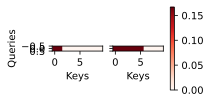

In [25]:
# shape of attention.attention_weights: (2, 1, 10)
d2l.show_heatmaps(attention.attention_weights.reshape((1, 2, 1, 10)), xlabel='Keys', ylabel='Queries')

### Scaled dot-product attention

In [26]:
#@save
class DotProductAttention(nn.Module):
    """Scaled-dot product attention."""
    def __init__(self, dropout, **kwargs):
        super(DotProductAttention, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)
    
    # shape of queries: (batch_size, no. of queries, key_size)
    # shape of keys: (batch_size, no. of key-value pairs, key_size)
    # shape of values: (batch_size, no. of key-value pairs, value_size)
    # shape of valid_lens: (batch_size,) or (batch_size, no. of queries)
    def forward(self, queries, keys, values, valid_lens=None):
        d = queries.shape[-1]
        scores = torch.bmm(queries, keys.transpose(1, 2)) / math.sqrt(d)
        self.attention_weights = masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)

In [27]:
queries = torch.normal(0, 1, (2, 1, 2))
attention = DotProductAttention(dropout=0.5)
attention.eval()
attention(queries, keys, values, valid_lens)

tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]])

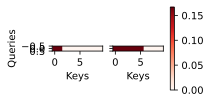

In [28]:
d2l.show_heatmaps(attention.attention_weights.reshape((1, 2, 1, 10)), xlabel='Keys', ylabel='Queries')